In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as st 
from tqdm import tqdm 
import os
os.chdir('D:\Shashi Katteri\Desktop\data sets to work on\Amazon Employee Access\Dataset_10')

In [2]:
df=pd.read_csv('Amazon_employee_access.csv')
df.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,target
0,39353,85475,117961,118300,123472,117905,117906,290919,117908,1
1,17183,1540,117961,118343,123125,118536,118536,308574,118539,1
2,36724,14457,118219,118220,117884,117879,267952,19721,117880,1
3,36135,5396,117961,118343,119993,118321,240983,290919,118322,1
4,42680,5905,117929,117930,119569,119323,123932,19793,119325,1


In [3]:
df1=df.astype(str)
df1['target']=df1['target'].astype(int)

In [4]:
#df1['ROLE_ROLLUP_12']=df1['ROLE_ROLLUP_1']+df1['ROLE_ROLLUP_2']
df1=df1.drop(['ROLE_TITLE','ROLE_FAMILY'],axis=1)


In [5]:
df1['target']=df1['target'].map({1:0,0:1})

In [6]:
from category_encoders import CatBoostEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import *

In [7]:
def AST_ecoding(train,test,columns,target,weight):
    t=train.copy()
    v=test.copy()
    gm=t[target].mean()
    for col in columns:
        gb=t.groupby(col)[target].agg(['count','mean'])
        count=gb['count']
        mean=gb['mean']
        gb['smooth']=(count*mean + weight*gm)/(count+weight)
        t[col+'_enc']=t[col].map(gb['smooth'])
        
        v[col+'_enc']=v[col].map(gb['smooth'])
        v[col+'_enc']=v[col+'_enc'].fillna(gm)
    v=v.drop(columns,axis=1)
    t=t.drop(columns,axis=1)
    return t,v

### Things to try

1. different weights for different columns
2. map normal target encoding to train instead of smooth

In [8]:
def aucroc(mod,x,y):
    pred=mod.predict(x)
    prob=mod.predict_proba(x)[:,1]
    auc=roc_auc_score(y,prob)
    acc=accuracy_score(y,pred)
    return auc
    #print('AUC_ROC= ',auc)
    #print('Accuracy= ',acc)
    #print('confusion matrix:\n',confusion_matrix(y,pred))

In [9]:
for i in df1.columns:
    a=df1.groupby(i)['target'].agg(['count','mean'])
    print('\n',i)
    print(a.describe())
    


 RESOURCE
             count         mean
count  7518.000000  7518.000000
mean      4.358739     0.067722
std      18.593512     0.212818
min       1.000000     0.000000
25%       1.000000     0.000000
50%       1.000000     0.000000
75%       3.000000     0.000000
max     839.000000     1.000000

 MGR_ID
             count         mean
count  4243.000000  4243.000000
mean      7.723073     0.059663
std       9.825344     0.172336
min       1.000000     0.000000
25%       2.000000     0.000000
50%       4.000000     0.000000
75%      10.000000     0.000000
max     152.000000     1.000000

 ROLE_ROLLUP_1
              count        mean
count    128.000000  128.000000
mean     256.007812    0.056580
std     1888.506795    0.103214
min        1.000000    0.000000
25%       15.000000    0.000000
50%       39.500000    0.035272
75%      108.250000    0.070181
max    21407.000000    1.000000

 ROLE_ROLLUP_2
             count        mean
count   177.000000  177.000000
mean    185.135593    

In [11]:
train,test=train_test_split(df1,test_size=0.3,random_state=7)
cols=list(df1.columns)
cols.remove('target')
target='target'
best_auc=0

for i in tqdm(range(20,200)):
    rf=RandomForestClassifier(n_estimators=200)
    t,v=AST_ecoding(train,test,cols,target,i)
    xtr=t.drop('target',axis=1)
    ytr=t['target']
    xts=v.drop('target',axis=1)
    yts=v['target']
    mod=rf.fit(xtr,ytr)
    auc=aucroc(mod,xts,yts)
    if auc>best_auc:
        best_auc=auc
        best_wt=i
print('best auc=',best_auc)
print('best_wt=',best_wt)

100%|██████████| 180/180 [20:50<00:00,  6.95s/it]


best auc= 0.8315955690269285
best_wt= 31


In [12]:
train,test=train_test_split(df1,test_size=0.3,random_state=7)
cols=list(df1.columns)
cols.remove('target')
target='target'
best_auc=0

for i in tqdm(range(20,200)):
    lgb=LGBMClassifier(n_estimators=200)
    t,v=AST_ecoding(train,test,cols,target,i)
    xtr=t.drop('target',axis=1)
    ytr=t['target']
    xts=v.drop('target',axis=1)
    yts=v['target']
    mod=lgb.fit(xtr,ytr)
    auc=aucroc(mod,xts,yts)
    if auc>best_auc:
        best_auc=auc
        best_wt=i
print('best auc=',best_auc)
print('best_wt=',best_wt)

100%|██████████| 180/180 [03:51<00:00,  1.29s/it]


best auc= 0.8415437970307375
best_wt= 87


In [13]:
from sklearn.linear_model import LogisticRegression
train,test=train_test_split(df1,test_size=0.3,random_state=7)
cols=list(df1.columns)
cols.remove('target')
target='target'
best_auc=0

for i in tqdm(range(20,200)):
    lr=LogisticRegression(solver='liblinear')
    t,v=AST_ecoding(train,test,cols,target,i)
    xtr=t.drop('target',axis=1)
    ytr=t['target']
    xts=v.drop('target',axis=1)
    yts=v['target']
    mod=lr.fit(xtr,ytr)
    auc=aucroc(mod,xts,yts)
    if auc>best_auc:
        best_auc=auc
        best_wt=i
print('best auc=',best_auc)
print('best_wt=',best_wt)

100%|██████████| 180/180 [01:11<00:00,  2.53it/s]


best auc= 0.8583319486218197
best_wt= 20


In [14]:
tr87,ts87=AST_ecoding(train,test,cols,target,87)
tr20,ts20=AST_ecoding(train,test,cols,target,20)

## LGBM feature engineering

In [15]:
t=tr87.copy()
v=ts87.copy()
xtr=t.drop('target',axis=1)
xtr_1=xtr.copy()
ytr=t['target']
xts=v.drop('target',axis=1)
xts_1=xts.copy()
yts=v['target']
xtr_1['sum']=xtr.sum(axis=1)
xtr_1['min']=xtr.min(axis=1)
xtr_1['max']=xtr.max(axis=1)
#xtr_1['skew']=xtr.skew(axis=1)
xtr_1.head()

,RESOURCE_enc,MGR_ID_enc,ROLE_ROLLUP_1_enc,ROLE_ROLLUP_2_enc,ROLE_DEPTNAME_enc,ROLE_FAMILY_DESC_enc,ROLE_CODE_enc,sum,min,max
8479,0.064827,0.075327,0.051709,0.048179,0.072098,0.066922,0.037533,0.416596,0.037533,0.075327
27904,0.057233,0.050433,0.051709,0.108771,0.064185,0.066481,0.036458,0.435272,0.036458,0.108771
20372,0.067709,0.053619,0.116891,0.092414,0.085898,0.020876,0.051452,0.488859,0.020876,0.116891
27140,0.054772,0.056597,0.051709,0.033000,0.042026,0.056597,0.092173,0.386875,0.033000,0.092173
30853,0.057884,0.051452,0.051709,0.033000,0.046517,0.054899,0.039630,0.335091,0.033000,0.057884


In [16]:
xts_1['sum']=xts.sum(axis=1)
xts_1['min']=xts.min(axis=1)
xts_1['max']=xts.max(axis=1)
#xts_1['skew']=xts.skew(axis=1)
xts_1.head()

,RESOURCE_enc,MGR_ID_enc,ROLE_ROLLUP_1_enc,ROLE_ROLLUP_2_enc,ROLE_DEPTNAME_enc,ROLE_FAMILY_DESC_enc,ROLE_CODE_enc,sum,min,max
9100,0.052513,0.058549,0.033461,0.033461,0.028300,0.093568,0.057831,0.357684,0.028300,0.093568
16681,0.010716,0.051977,0.051709,0.082726,0.051208,0.066481,0.036669,0.351487,0.010716,0.082726
31698,0.051977,0.037140,0.051709,0.044875,0.034939,0.038091,0.032178,0.290909,0.032178,0.051977
4021,0.038013,0.061553,0.049170,0.057292,0.057488,0.066481,0.040341,0.370339,0.038013,0.066481
11313,0.058549,0.057884,0.066086,0.066086,0.036566,0.057884,0.054972,0.398027,0.036566,0.066086


In [17]:
def aucroc(mod,x,y):
    pred=mod.predict(x)
    prob=mod.predict_proba(x)[:,1]
    auc=roc_auc_score(y,prob)
    acc=accuracy_score(y,pred)
    
    print('AUC_ROC= ',auc)
    print('Accuracy= ',acc)
    print('confusion matrix:\n',confusion_matrix(y,pred))

In [18]:
lgb=LGBMClassifier()

#t,v=AST_ecoding(train,test,cols,target,i)



lgb=LGBMClassifier(n_estimators=200)

mod=lgb.fit(xtr_1,ytr)
aucroc(mod,xts_1,yts)


AUC_ROC=  0.8415883542583673
Accuracy=  0.9389685688129387
confusion matrix:
 [[9091  186]
 [ 414  140]]


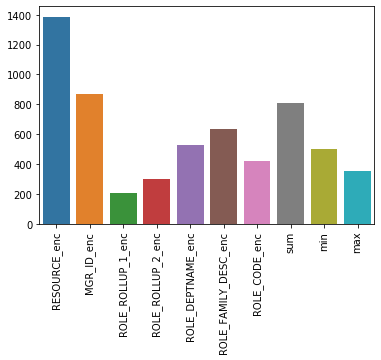

In [19]:
plt.xticks(rotation=90)
sns.barplot(y=mod.feature_importances_,x=xtr_1.columns)

## Logistic Regression

In [20]:
t=tr20.copy()
v=ts20.copy()
xtr=t.drop('target',axis=1)
xtr_1=xtr.copy()
ytr=t['target']
xts=v.drop('target',axis=1)
xts_1=xts.copy()
yts=v['target']
xtr_1['sum']=xtr.sum(axis=1)
xtr_1['min']=xtr.min(axis=1)
xtr_1['max']=xtr.max(axis=1)
xtr_1['skew']=xtr.skew(axis=1)
xtr_1.head()

,RESOURCE_enc,MGR_ID_enc,ROLE_ROLLUP_1_enc,ROLE_ROLLUP_2_enc,ROLE_DEPTNAME_enc,ROLE_FAMILY_DESC_enc,ROLE_CODE_enc,sum,min,max,skew
8479,0.080407,0.092104,0.051678,0.047811,0.084534,0.081307,0.025992,0.463833,0.025992,0.092104,-0.715044
27904,0.053226,0.034441,0.051678,0.111635,0.066941,0.066592,0.026910,0.411423,0.026910,0.111635,1.111042
20372,0.094391,0.041821,0.131054,0.101987,0.099780,0.006616,0.036593,0.512242,0.006616,0.131054,-0.331604
27140,0.045038,0.050912,0.051678,0.032379,0.027833,0.050912,0.107093,0.365845,0.027833,0.107093,1.886094
30853,0.055761,0.036593,0.051678,0.032379,0.033922,0.049341,0.028312,0.287986,0.028312,0.055761,0.290983


In [21]:
xts_1['sum']=xts.sum(axis=1)
xts_1['min']=xts.min(axis=1)
xts_1['max']=xts.max(axis=1)
xts_1['skew']=xts.skew(axis=1)
xts_1.head()

,RESOURCE_enc,MGR_ID_enc,ROLE_ROLLUP_1_enc,ROLE_ROLLUP_2_enc,ROLE_DEPTNAME_enc,ROLE_FAMILY_DESC_enc,ROLE_CODE_enc,sum,min,max,skew
9100,0.039033,0.058549,0.021869,0.021869,0.022065,0.102069,0.057582,0.323035,0.021869,0.102069,1.230016
16681,0.005329,0.037774,0.051678,0.083984,0.041750,0.066592,0.036083,0.323189,0.005329,0.083984,-0.106139
31698,0.037774,0.025572,0.051678,0.044584,0.030605,0.033568,0.027415,0.251196,0.025572,0.051678,0.748790
4021,0.017477,0.067843,0.047434,0.056821,0.055666,0.066592,0.034476,0.346309,0.017477,0.067843,-0.948340
11313,0.058549,0.055761,0.070440,0.070440,0.024968,0.055761,0.053405,0.389324,0.024968,0.070440,-1.469701


In [22]:
lr=LogisticRegression()
mod=lr.fit(xtr_1,ytr)
aucroc(mod,xts_1,yts)

AUC_ROC=  0.8558277935144134
Accuracy=  0.9449699928796663
confusion matrix:
 [[9180   97]
 [ 444  110]]


In [23]:
mod=lr.fit(xtr,ytr)
aucroc(mod,xts,yts)

AUC_ROC=  0.8583321431948662
Accuracy=  0.9445631166717526
confusion matrix:
 [[9182   95]
 [ 450  104]]


In [24]:
yts.value_counts()

0    9277
1     554
Name: target, dtype: int64